# Image Classification with CIFAR-10 dataset

In [1]:
import pickle
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.utils import shuffle

### Understanding the data

The dataset is broken into batches, named data_batch_1, data_batch_2, etc. The original one batch data 
is (10000 x 3072) dimensional, where the number of columns (10000), indicates the number of sample 
data and the row vector, (3072) represents an color image of 32x32 pixels.
The label data is just a list of 10000 numbers in the range 0-9, which corresponds to each of the 10 
classes in CIFAR-10.
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In [2]:
def load_cifar():
    trn_data, trn_labels, tst_data, tst_labels = [], [], [], []
    def unpickle(file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='latin1')
        return data
    for i in range(1):
        batchName = './data/data_batch_{0}'.format(i + 1)
        unpickled = unpickle(batchName)
        trn_data.extend(unpickled['data'])
        trn_labels.extend(unpickled['labels'])
    unpickled = unpickle('./data/test_batch')
    tst_data.extend(unpickled['data'])
    tst_labels.extend(unpickled['labels'])
    return trn_data, trn_labels, tst_data, tst_labels

In [3]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    features = batch['data']
    labels = batch['labels']
    return features, labels

In [4]:
trn_data, trn_labels, tst_data, tst_labels = load_cifar()

In [5]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Explore the Data

The display defined below answers some of questions like in a given batch of data 
* What are all possible labels?
* What is the range of values for the image data?"
* lable of a particular image?

In [6]:
def display (cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cifar10_batch(cifar10_dataset_folder_path, batch_id)
    
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None 
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = np.array(features[sample_id])
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    image = sample_image.reshape(3, 32, 32).transpose(1, 2, 0)
    plt.imshow(image, cmap = plt.cm.bone)

Label Counts of [0](AIRPLANE) : 1005
Label Counts of [1](AUTOMOBILE) : 974
Label Counts of [2](BIRD) : 1032
Label Counts of [3](CAT) : 1016
Label Counts of [4](DEER) : 999
Label Counts of [5](DOG) : 937
Label Counts of [6](FROG) : 1030
Label Counts of [7](HORSE) : 1001
Label Counts of [8](SHIP) : 1025
Label Counts of [9](TRUCK) : 981

Example of Image 300:
Image - Min Value: 6 Max Value: 248
Image - Shape: (3072,)
Label - Label Id: 2 Name: bird


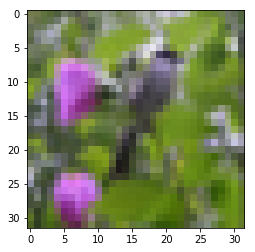

In [7]:
display('./data/', 1, 300)

### Preprocessing 

#### Normalize
#### Min-Max Normalization

this simply makes all x values to range between 0 and 1.
y = (x-min) / (max-min)

Normalize function takes an image data, x, and returns it as a normalized array. The values in the original data is going to be transformed in range of 0 to 1, inclusive. A simply answer to why normalization should be performed is somewhat related to activation function.

For example, sigmoid activation function takes an input value and outputs a new value ranging from 0 to 1. When the input value is somewhat large, the output value easily reaches the max value 1. Similarily, when the input value is somewhat small, the output value easily reaches the max value 0.

Now, when we think about the image data, all values originally ranges from 0 to 255. This sounds like when it is passed into sigmoid function, the output is almost always 1, and when it is passed into ReLu function, the output could be very huge. In order to avoid this issue, ideally, it is better let all the values be around 0 and 1.

In [8]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x - min_val) / (max_val - min_val)
    return x

In [9]:
trn_data = normalize(trn_data)
tst_data = normalize(tst_data)

### Representation and Dimensionality Reduction 

#### PCA

The main idea of principal component analysis (PCA) is to reduce the dimensionality of a data set 
consisting of many variables correlated with each other, either heavily or lightly, while retaining 
the variation present in the dataset, up to the maximum extent.
The number of components for PCA are decided by retatining the variance upto 94%.

In [10]:
pca = PCA()
pca.fit_transform(trn_data)
#number of components
k = 0
total = sum(pca.explained_variance_)
current_sum = 0
while(current_sum / total < 0.94):
    current_sum += pca.explained_variance_[k]
    k += 1
pca = PCA(n_components=k, whiten=True)

Number of components used here is 175 (175 features)

In [11]:
trn_data_pca = pca.fit_transform(trn_data, k)
tst_data_pca = pca.fit_transform(tst_data, k)

#### LDA

The goal is to project a dataset onto a lower-dimensional space with good class-separability in order 
avoid overfitting (“curse of dimensionality”) and also reduce computational costs.

In [10]:
def lda(image, label):
    lda = LDA() 
    lda_image = lda.fit_transform(image, label)
    return lda_image

Number of components used here is 9 

In [11]:
trn_data_lda = lda(trn_data, trn_labels)
tst_data_lda = lda(tst_data, tst_labels)

### Split into Train and Validation

In [12]:
X_train, X_val, y_train, y_val = train_test_split(trn_data, trn_labels, test_size = 0.2)

In [13]:
X_train_pca, X_val_pca, y_train_pca, y_val_pca = train_test_split(trn_data_pca, trn_labels, test_size = 0.2)

In [12]:
X_train_lda, X_val_lda, y_train_lda, y_val_lda = train_test_split(trn_data_lda, trn_labels, test_size = 0.2)

### Plot Function

In [17]:
def plot(results_df, plot_list):
    lines = 'Parameters'
    nrows = 2
    ncols = int(np.ceil(len(plot_list) / 2.))
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (6 * ncols, 4 * nrows))
    axes[0, 0].get_shared_y_axes().join(axes[0, 0], axes[0, 1])

    for ax, (x_axis, y_axis) in zip(axes.ravel(), plot_list):
        for criterion, group_df in results_df.groupby(lines):
            group_df.plot(x = x_axis, y = y_axis, label = criterion, ax = ax)
        ax.set_title(y_axis)
        ax.legend(title = lines)

    fig.tight_layout()
    plt.show()

### Classification

#### Logistic Regression

#### Hyperparameters
* loss - For logistic regression it is 'log' (default).
* regularization - l2 (default).
* tol - The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol).         I am taking different stopping criterion and comparing performance.
* learning_rate - The learning rate.

In [13]:
estimator_dict = {
    'Parameters-1':
    SGDClassifier(tol = None, learning_rate = 'constant', eta0 = 0.01),
    'Parameters-2':
    SGDClassifier(tol = 0.01, learning_rate = 'constant', eta0 = 0.001),
    'Parameters-3':
    SGDClassifier(tol = 0.01, learning_rate = 'constant', penalty = 'l1', eta0 = 0.01),
    'Parameters -4':
    SGDClassifier(tol = None, learning_rate = 'constant', penalty = 'l1', eta0 = 0.001),
}

##### Raw Data

In [87]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train, y_train)
        fit_time = time.time() - start
        val_score = estimator.score(X_val, y_val)
        test_score = estimator.score(tst_data, tst_labels)
        y_pred = estimator.predict(tst_data)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [88]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

From the results below we can see that both validation and testing accuracy is better with no 
stopping criterion. In my opinion this is the case because in other conditions whenever we get any 
local maxima with loss greater than parameter **tol** it stops, but without any stopping criterion it runs till 
number of iterations and find the best result. 
<br/>Fit time with no stopping criterion is increasing, but with stopping criterion it increases and 
becomes almost constant.
<br/>I swept over a certain range for several parameters in an attempt to find the optimal learning settings. 
<br/>The hyperparameters tuned were:
<br/>Learning rate α = [1e2, 1e1, 1e2, 1e1]
<br/>Regularization = [l2, l1, l2, l2]
<br/>Stopping condition = [None, 0.01, 0.01, None]
<br/>From the results below I found out that the best logistic regression classifier had the learning rate of 0.001 and regularization l1. It yields an accuracy of 33.6% on validation data set, and 34.31% on test data set.

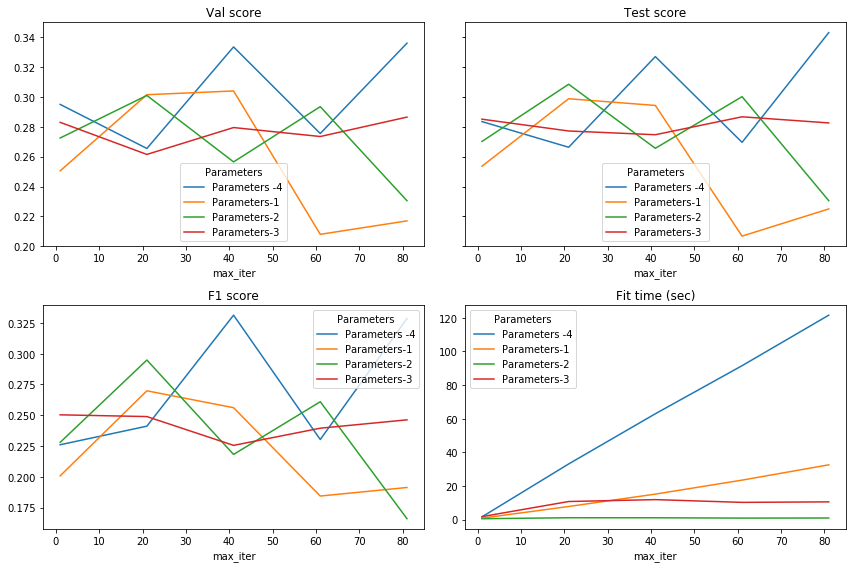

In [89]:
plot(results_df, plot_list)

In [90]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.871743,0.2505,0.2536,0.200740
1,Parameters-1,21,7.811438,0.3015,0.2988,0.269865
2,Parameters-1,41,15.174274,0.3040,0.2943,0.256136
3,Parameters-1,61,23.490106,0.2080,0.2068,0.184316
4,Parameters-1,81,32.593110,0.2170,0.2250,0.191274
5,Parameters-2,1,0.538872,0.2725,0.2702,0.227953
6,Parameters-2,21,1.120206,0.3010,0.3085,0.294877
7,Parameters-2,41,1.100111,0.2565,0.2656,0.218145
8,Parameters-2,61,0.903709,0.2935,0.3002,0.260983
9,Parameters-2,81,0.962466,0.2305,0.2305,0.165883


##### PCA

PCA feature reduction reduces accuracy. This is because PCA is an algorithm that does not consider
the response variable / prediction target into account. PCA will treat the feature has large variance as 
important features, but the feature has large variance can have noting to do with the prediction target.
This means, we can produce a lot of useless features and eliminate useful features after PCA.
For 4th parameter set it shows the best accuracy of 0.14 on test dataset. 
For all the set of parameters the accuracies are almost simillar. 
Fit time shows the same variations as it is showing for raw data.

In [16]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_pca, y_train_pca)
        fit_time = time.time() - start
        n_iter = estimator.n_iter_
        val_score = estimator.score(X_val_pca, y_val_pca)
        test_score = estimator.score(tst_data_pca, tst_labels)
        y_pred = estimator.predict(tst_data_pca)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [17]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

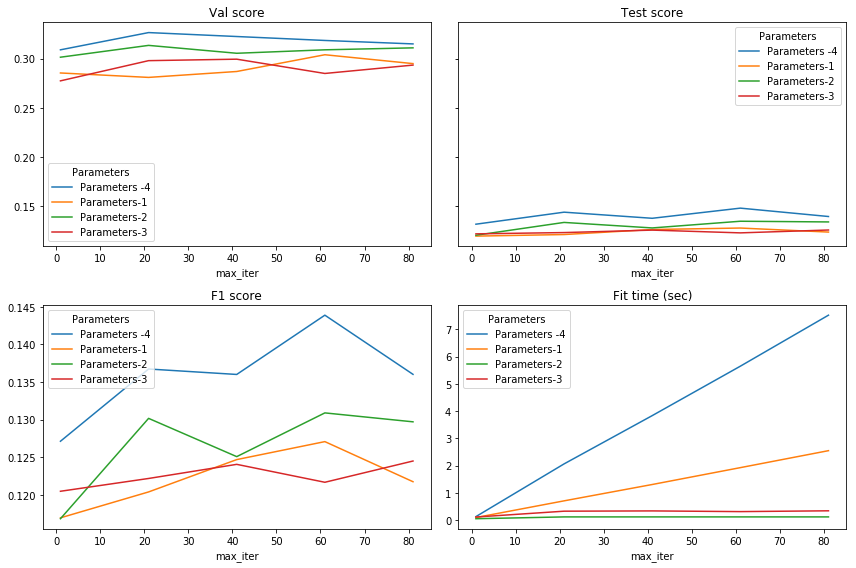

In [18]:
plot(results_df, plot_list)

In [19]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.088569,0.2855,0.1199,0.116942
1,Parameters-1,21,0.701824,0.2810,0.1215,0.120387
2,Parameters-1,41,1.302137,0.2870,0.1266,0.124686
3,Parameters-1,61,1.921776,0.3040,0.1281,0.127076
4,Parameters-1,81,2.545081,0.2950,0.1240,0.121745
5,Parameters-2,1,0.045500,0.3015,0.1208,0.116825
6,Parameters-2,21,0.112019,0.3135,0.1338,0.130167
7,Parameters-2,41,0.112097,0.3055,0.1282,0.125080
8,Parameters-2,61,0.112302,0.3090,0.1350,0.130895
9,Parameters-2,81,0.112132,0.3110,0.1343,0.129707


##### LDA

From the results below accuracy after using LDA increased a lot on both validation and test. 
On testing it is 38% whereas for raw data it is 32%. Here best accuracy is of parameter-1 which is different
from Raw data and PCA.
LDA is used for classification as it helps to find the boundaries around clusters of classes. 
It projects data points on a line so that clusters are as separated as possible, with each 
cluster having a relative (close) distance to a centroid.
Fit time is showing same variations as it is showing for PCA and Raw data.

In [14]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_lda, y_train_lda)
        fit_time = time.time() - start
        n_iter = estimator.n_iter_
        val_score = estimator.score(X_val_lda, y_val_lda)
        test_score = estimator.score(tst_data_lda, tst_labels)
        y_pred = estimator.predict(tst_data_lda)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [15]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

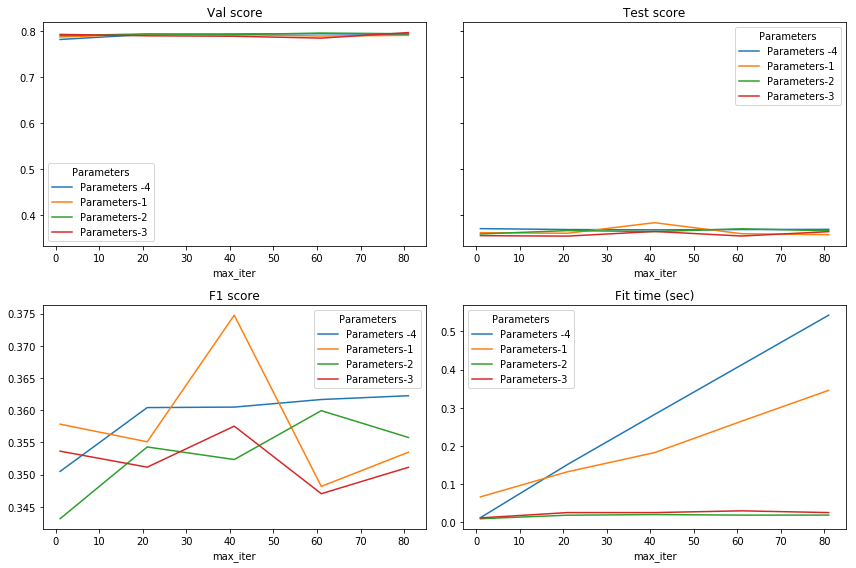

In [18]:
plot(results_df, plot_list)

In [19]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.066721,0.7875,0.3619,0.357835
1,Parameters-1,21,0.132376,0.7935,0.3606,0.355096
2,Parameters-1,41,0.182476,0.7925,0.3836,0.374743
3,Parameters-1,61,0.264731,0.7895,0.3596,0.348174
4,Parameters-1,81,0.345571,0.7910,0.3575,0.353481
5,Parameters-2,1,0.009570,0.7905,0.3591,0.343161
6,Parameters-2,21,0.018788,0.7940,0.3664,0.354293
7,Parameters-2,41,0.020426,0.7925,0.3643,0.352343
8,Parameters-2,61,0.018994,0.7960,0.3703,0.359928
9,Parameters-2,81,0.019080,0.7945,0.3661,0.355768


#### Linear SVM

Support Vector Machine is a supervised learning model
usually used for classification and regression analysis. Its
core idea is the principle of structural risk minimisation,
which in practice is to find a hyperplane represents the
maximum margin of separation between classes

#### Hyperparameters
* loss - For SVM it is 'hinge'.
* regularization - l2 (default).
* tol - The stopping criterion. If it is not None, the iterations will stop when (loss > previous_loss - tol).         
I am taking different stopping criterion and comparing performance.

In [38]:
estimator_dict = {
    'Parameters-1':
    SGDClassifier(loss = 'hinge', penalty = "l2", tol = None),
    'Parameters-2':
    SGDClassifier(loss = 'hinge', penalty = "l2", tol = 0.1),
    'Parameters-3':
    SGDClassifier(loss = 'hinge', penalty = "l2", tol = 0.0001),
}

##### Raw Data

From the results shown below accuracy for linear SVM is improving on using stopping conditions. With stopping 
condition in case 2 (max value of **tol**) the accuracy achieved is highest. 
With first set of parameters both validation and test have almost same acuracy but for other set it is showing
difference.

In [39]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train, y_train)
        fit_time = time.time() - start
        n_iter = estimator.n_iter_
        val_score = estimator.score(X_val, y_val)
        test_score = estimator.score(tst_data, tst_labels)
        y_pred = estimator.predict(tst_data)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [40]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

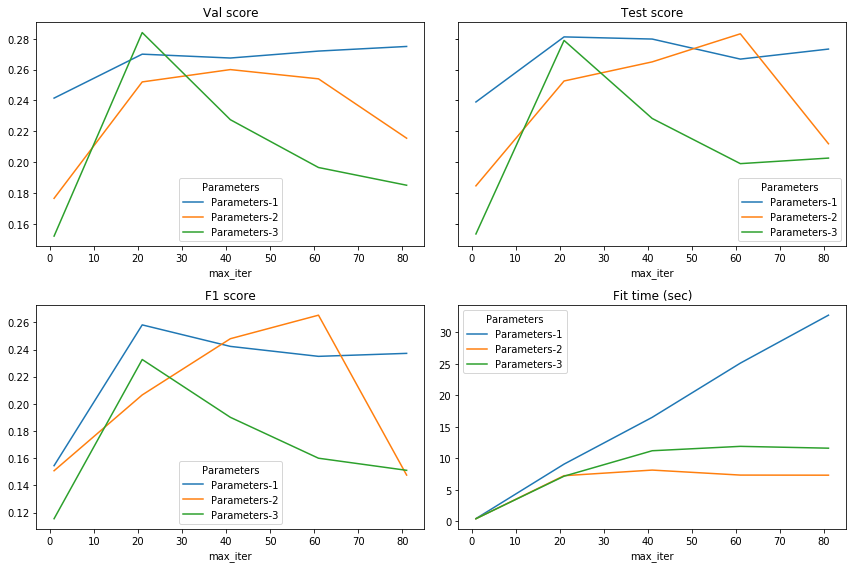

In [41]:
plot(results_df, plot_list)

In [42]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.436737,0.2415,0.2390,0.154518
1,Parameters-1,21,9.085147,0.2700,0.2812,0.258131
2,Parameters-1,41,16.510931,0.2675,0.2798,0.242303
3,Parameters-1,61,25.110225,0.2720,0.2668,0.234970
4,Parameters-1,81,32.721469,0.2750,0.2733,0.237168
5,Parameters-2,1,0.421465,0.1765,0.1846,0.150785
6,Parameters-2,21,7.250233,0.2520,0.2526,0.206576
7,Parameters-2,41,8.139427,0.2600,0.2650,0.247951
8,Parameters-2,61,7.345096,0.2540,0.2832,0.265273
9,Parameters-2,81,7.330199,0.2155,0.2119,0.147596


##### PCA

On using PCA accuracy is decreasing because of the same reason as explanied above and there is not much change in accuracies on chaning parameters. Same trend as that of Logistic Regression with PCA.

In [43]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_pca, y_train_pca)
        fit_time = time.time() - start
        n_iter = estimator.n_iter_
        val_score = estimator.score(X_val_pca, y_val_pca)
        test_score = estimator.score(tst_data_pca, tst_labels)
        y_pred = estimator.predict(tst_data_pca)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [44]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

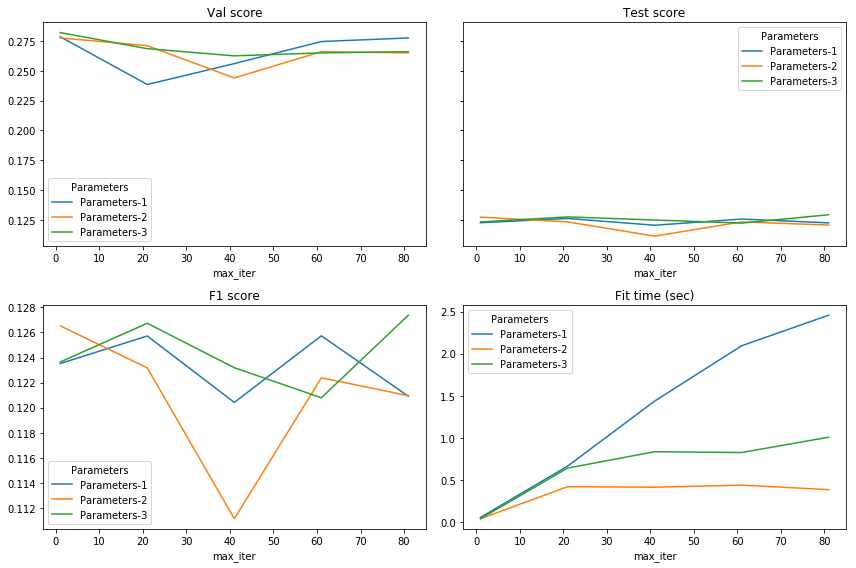

In [45]:
plot(results_df, plot_list)

In [46]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.055208,0.2785,0.1227,0.123519
1,Parameters-1,21,0.663369,0.2385,0.1263,0.125716
2,Parameters-1,41,1.435780,0.2560,0.1206,0.120419
3,Parameters-1,61,2.093261,0.2745,0.1258,0.125730
4,Parameters-1,81,2.456415,0.2775,0.1226,0.120909
5,Parameters-2,1,0.039140,0.2775,0.1274,0.126528
6,Parameters-2,21,0.419034,0.2710,0.1234,0.123173
7,Parameters-2,41,0.413304,0.2440,0.1115,0.111147
8,Parameters-2,61,0.438193,0.2660,0.1234,0.122381
9,Parameters-2,81,0.384375,0.2650,0.1208,0.120954


##### LDA

From the results below accuracy after using LDA increased on both validation and test. On test data set it is 
approx. 38%. 

In [47]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_lda, y_train_lda)
        fit_time = time.time() - start
        val_score = estimator.score(X_val_lda, y_val_lda)
        test_score = estimator.score(tst_data_lda, tst_labels)
        y_pred = estimator.predict(tst_data_lda)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [48]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

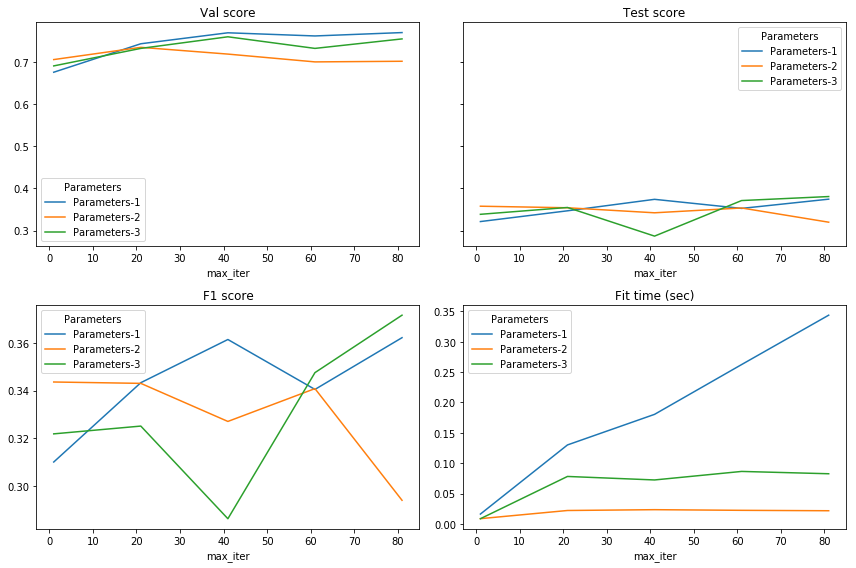

In [49]:
plot(results_df, plot_list)

In [50]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.016159,0.6755,0.3215,0.310134
1,Parameters-1,21,0.130070,0.7430,0.3470,0.343297
2,Parameters-1,41,0.180463,0.7690,0.3742,0.361351
3,Parameters-1,61,0.262502,0.7615,0.3527,0.340476
4,Parameters-1,81,0.343871,0.7695,0.3746,0.362116
5,Parameters-2,1,0.008585,0.7055,0.3579,0.343585
6,Parameters-2,21,0.022051,0.7345,0.3542,0.343014
7,Parameters-2,41,0.023389,0.7185,0.3423,0.327097
8,Parameters-2,61,0.022332,0.7000,0.3537,0.340820
9,Parameters-2,81,0.021649,0.7015,0.3200,0.294126


#### Kernel SVM (RBF)

#### Hyperparameters
* C - penalty parameter C of the error term.
* gamma - Kernel coefficient for ‘rbf’.

In [66]:
estimator_dict = {
    'Parameters-1':
    SVC(gamma='auto'),
    'Parameters-2':
    SVC(C = 0.5, gamma = 0.4),
    'Parameters-3':
    SVC(C = 1, gamma = 0.2),
}

##### Raw Data

In [67]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train, y_train)
        fit_time = time.time() - start
        val_score = estimator.score(X_val, y_val)
        test_score = estimator.score(tst_data, tst_labels)
        y_pred = estimator.predict(tst_data)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [68]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

The best result is obtained from parameters set 2 having C = 0.5 and gamma = 0.4, with accuracy on training 
dataset 23% and 23% on validation dataset 

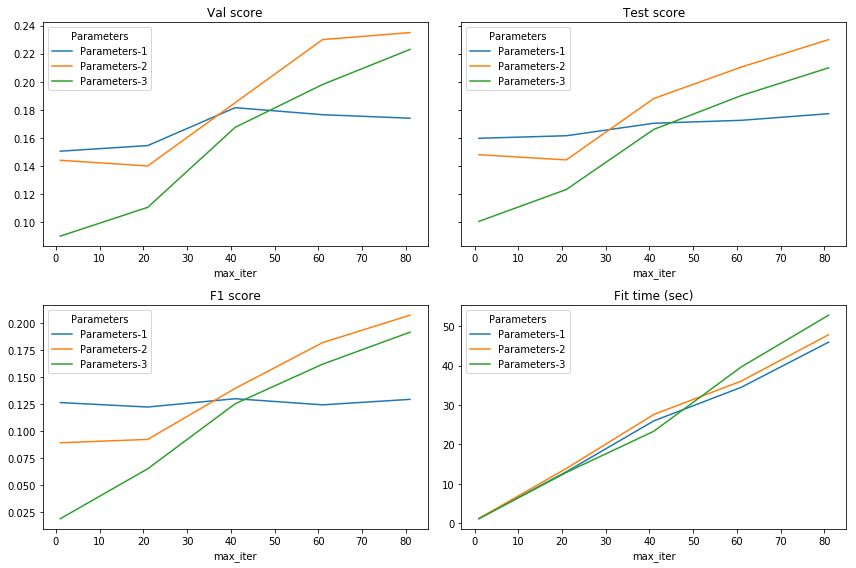

In [69]:
plot(results_df, plot_list)

In [70]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,1.205357,0.1505,0.1597,0.126645
1,Parameters-1,21,13.075725,0.1545,0.1615,0.122534
2,Parameters-1,41,25.975796,0.1815,0.1704,0.130211
3,Parameters-1,61,34.490701,0.1765,0.1725,0.124557
4,Parameters-1,81,45.945847,0.1740,0.1772,0.129615
5,Parameters-2,1,1.235600,0.1440,0.1480,0.089461
6,Parameters-2,21,13.907623,0.1400,0.1443,0.092563
7,Parameters-2,41,27.592933,0.1850,0.1880,0.139744
8,Parameters-2,61,36.068684,0.2300,0.2104,0.182090
9,Parameters-2,81,47.834005,0.2350,0.2300,0.207498


##### PCA

In [72]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_pca, y_train_pca)
        fit_time = time.time() - start
        val_score = estimator.score(X_val_pca, y_val_pca)
        test_score = estimator.score(tst_data_pca, tst_labels)
        y_pred = estimator.predict(tst_data_pca)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [73]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

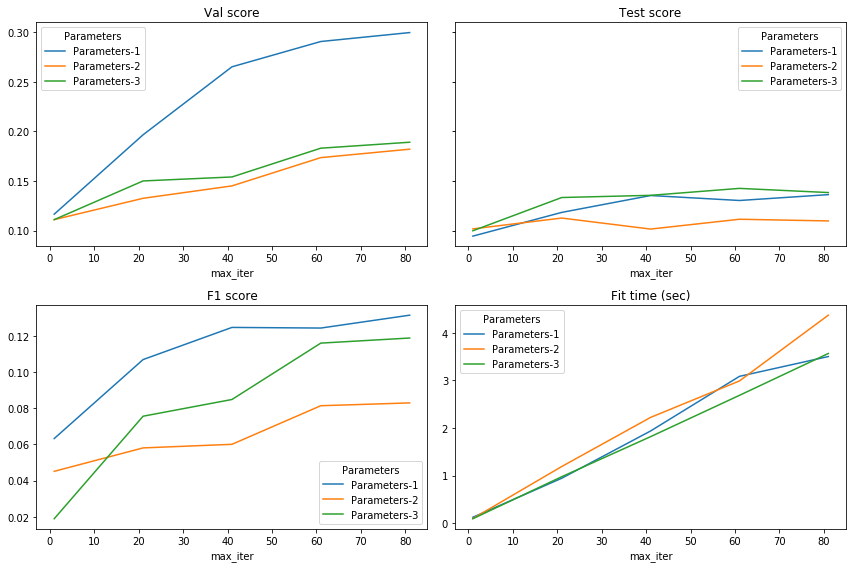

In [74]:
plot(results_df, plot_list)

In [75]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.125351,0.1165,0.0944,0.063276
1,Parameters-1,21,0.944869,0.1965,0.1183,0.106986
2,Parameters-1,41,1.937260,0.2650,0.1353,0.124779
3,Parameters-1,61,3.084547,0.2905,0.1303,0.124429
4,Parameters-1,81,3.500460,0.2995,0.1362,0.131555
5,Parameters-2,1,0.099052,0.1110,0.1017,0.045135
6,Parameters-2,21,1.190897,0.1325,0.1126,0.058093
7,Parameters-2,41,2.222242,0.1450,0.1015,0.060081
8,Parameters-2,61,2.988121,0.1735,0.1114,0.081444
9,Parameters-2,81,4.368972,0.1820,0.1097,0.082997


##### LDA

In [77]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_lda, y_train_lda)
        fit_time = time.time() - start
        val_score = estimator.score(X_val_lda, y_val_lda)
        test_score = estimator.score(tst_data_lda, tst_labels)
        y_pred = estimator.predict(tst_data_lda)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [78]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

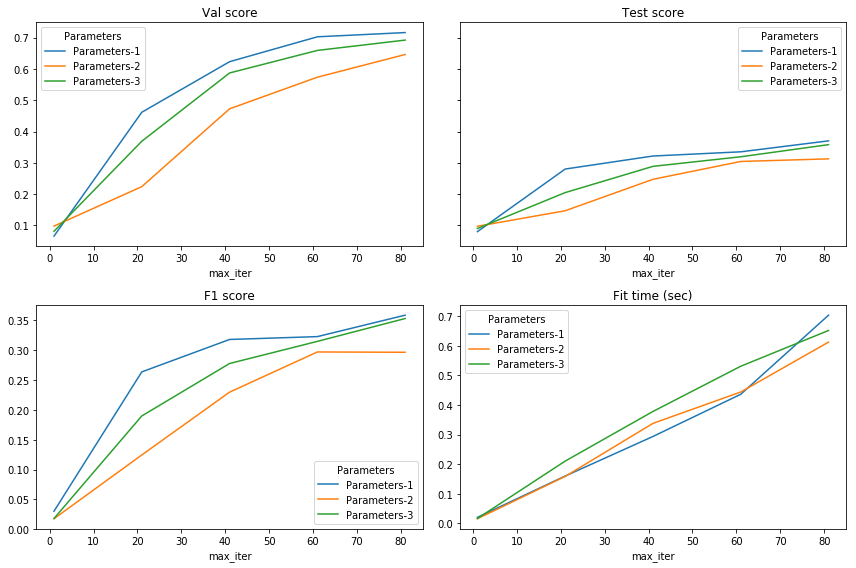

In [79]:
plot(results_df, plot_list)

In [80]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.020189,0.0660,0.0802,0.030366
1,Parameters-1,21,0.159913,0.4615,0.2802,0.263635
2,Parameters-1,41,0.293802,0.6230,0.3218,0.317922
3,Parameters-1,61,0.436481,0.7025,0.3352,0.322694
4,Parameters-1,81,0.704027,0.7160,0.3702,0.358585
5,Parameters-2,1,0.015548,0.0980,0.0974,0.017823
6,Parameters-2,21,0.158635,0.2240,0.1470,0.124578
7,Parameters-2,41,0.338115,0.4725,0.2474,0.229707
8,Parameters-2,61,0.444173,0.5735,0.3044,0.297002
9,Parameters-2,81,0.612956,0.6460,0.3127,0.296468


#### MLP

#### Hyperparameters
* hidden_layer_sizes - The ith element represents the number of neurons in the ith hidden layer. 
* early_stopping - use early stopping to terminate training when validation score is not improving. 
* activation - used default 'relu'

In [51]:
estimator_dict = {
    'Parameters-1':
    MLPClassifier(hidden_layer_sizes = (3, 2)),
    'Parameters-2':
    MLPClassifier(hidden_layer_sizes = (3, 1)),
    'Parameters-3':
    MLPClassifier(hidden_layer_sizes = (5, 2)),
    'Parameters-4':
    MLPClassifier(hidden_layer_sizes = (5, 2), early_stopping=True),
}

##### Raw Data

In [52]:
results = []
import sklearn
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train, y_train)
        fit_time = time.time() - start
        val_score = estimator.score(X_val, y_val)
        test_score = estimator.score(tst_data, tst_labels)
        y_pred = estimator.predict(tst_data)  
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [53]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

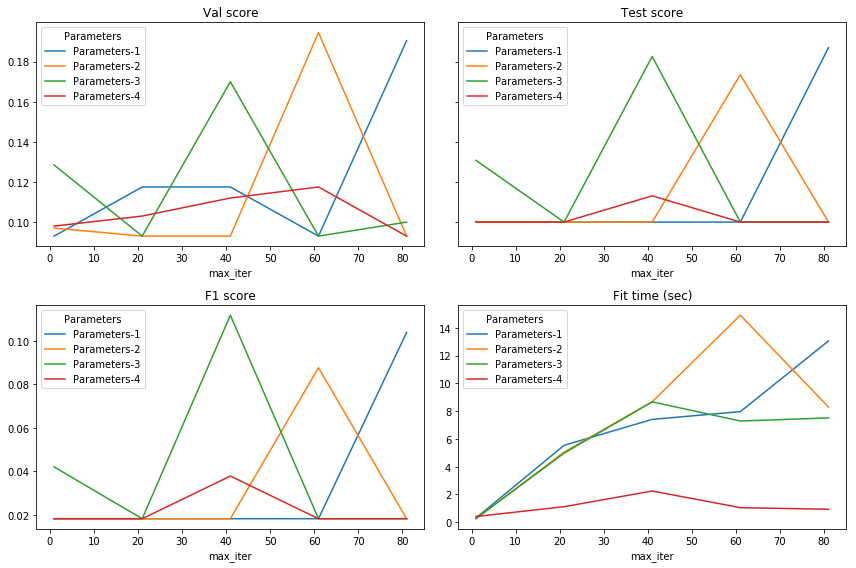

In [54]:
plot(results_df, plot_list)

In [55]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.304191,0.0930,0.1000,0.018182
1,Parameters-1,21,5.540575,0.1175,0.1000,0.018182
2,Parameters-1,41,7.409235,0.1175,0.1000,0.018182
3,Parameters-1,61,7.966246,0.0930,0.1000,0.018182
4,Parameters-1,81,13.059248,0.1905,0.1870,0.103857
5,Parameters-2,1,0.254794,0.0970,0.1000,0.018182
6,Parameters-2,21,5.050005,0.0930,0.1000,0.018182
7,Parameters-2,41,8.679954,0.0930,0.1000,0.018182
8,Parameters-2,61,14.914745,0.1945,0.1735,0.087607
9,Parameters-2,81,8.291854,0.0930,0.1000,0.018182


##### PCA

In [56]:
results = []
import sklearn
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_pca, y_train_pca)
        fit_time = time.time() - start
        val_score = estimator.score(X_val_pca, y_val_pca)
        test_score = estimator.score(tst_data_pca, tst_labels)
        y_pred = estimator.predict(tst_data_pca)  
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [57]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

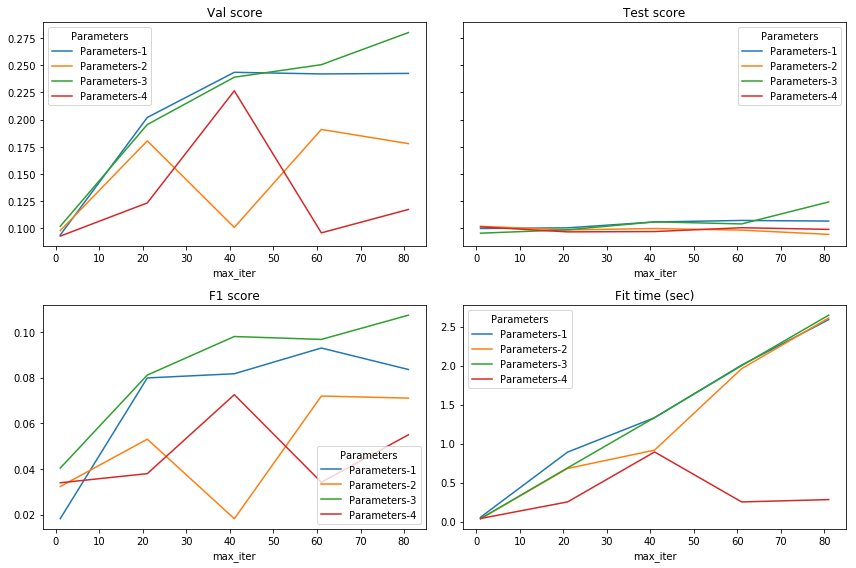

In [58]:
plot(results_df, plot_list)

In [59]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.055427,0.0940,0.1000,0.018182
1,Parameters-1,21,0.890077,0.2020,0.1006,0.079885
2,Parameters-1,41,1.331633,0.2435,0.1060,0.081722
3,Parameters-1,61,2.005972,0.2420,0.1074,0.093005
4,Parameters-1,81,2.588578,0.2425,0.1068,0.083587
5,Parameters-2,1,0.036438,0.0980,0.1020,0.032279
6,Parameters-2,21,0.680607,0.1805,0.0987,0.053045
7,Parameters-2,41,0.915830,0.1010,0.1000,0.018182
8,Parameters-2,61,1.959928,0.1910,0.0985,0.071948
9,Parameters-2,81,2.609870,0.1780,0.0946,0.071049


##### LDA

In [61]:
results = []
for estimator_name, estimator in estimator_dict.items():
    for max_iter in range(1, 100, 20):
        estimator.set_params(max_iter = max_iter)
        start = time.time()
        estimator.fit(X_train_lda, y_train_lda)
        fit_time = time.time() - start
        n_iter = estimator.n_iter_
        val_score = estimator.score(X_val_lda, y_val_lda)
        test_score = estimator.score(tst_data_lda, tst_labels)
        y_pred = estimator.predict(tst_data_lda)
        f1score = sklearn.metrics.f1_score(tst_labels, y_pred, average = 'weighted')        
        results.append((estimator_name, max_iter, fit_time, val_score, test_score, f1score))

In [62]:
columns = ['Parameters', 'max_iter', 'Fit time (sec)', 'Val score', 'Test score', 'F1 score']
results_df = pd.DataFrame(results, columns = columns)
plot_list = [
    ('max_iter', 'Val score'),
    ('max_iter', 'Test score'),
    ('max_iter', 'F1 score'),
    ('max_iter', 'Fit time (sec)'),]

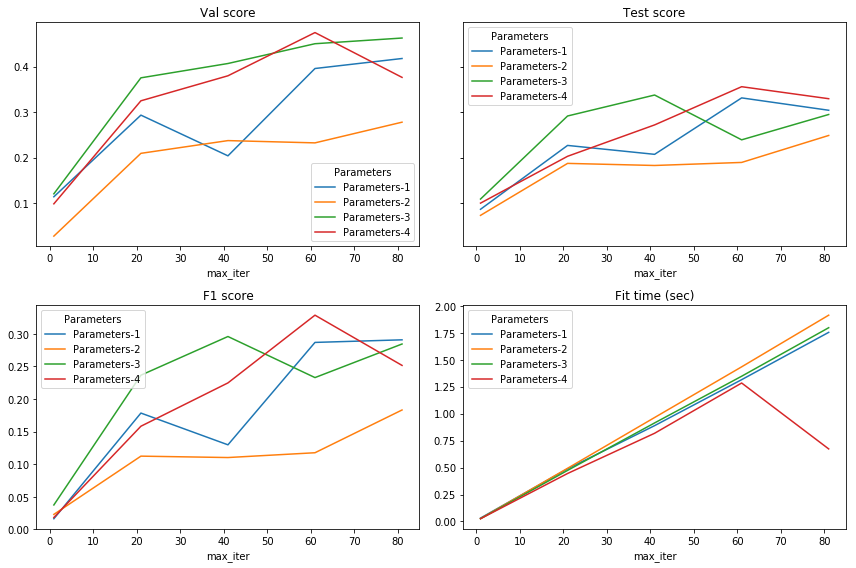

In [63]:
plot(results_df, plot_list)

In [64]:
results_df

,Parameters,max_iter,Fit time (sec),Val score,Test score,F1 score
0,Parameters-1,1,0.031544,0.1140,0.0865,0.016273
1,Parameters-1,21,0.488294,0.2935,0.2269,0.178429
2,Parameters-1,41,0.888745,0.2040,0.2073,0.129696
3,Parameters-1,61,1.314976,0.3960,0.3314,0.286864
4,Parameters-1,81,1.753722,0.4180,0.3042,0.290834
5,Parameters-2,1,0.026786,0.0275,0.0731,0.022922
6,Parameters-2,21,0.493288,0.2095,0.1874,0.112303
7,Parameters-2,41,0.964071,0.2375,0.1828,0.110167
8,Parameters-2,61,1.434062,0.2325,0.1895,0.117529
9,Parameters-2,81,1.912982,0.2780,0.2488,0.183158


### Observations

Goal of the experiment performed above is to analyse the performance of different classifiers on CIFAR-1O dataset.
<br/> Four classifiers are used for this experiment :
* Logistic Regression
* Linear SVM
* Kernel SVM (RBF)
* MLP
<br/> on three types of data representation :
* Original data
* Reduction using PCA
* Reduction using LDA

Score table of each of the classifiers with all three representations is shown below:
#### Score Table 
<img src = "Table.png">

As seen in Table above there was a clear outlier in terms of both accuracy, f-score; the Logistic Regression with LDA. The Kernel SVM model was one of the slowest classifiers  and the MLP classifier is one with least
accuracy. Both Linear SVM and Kernel SVM has simillar accuracy on each representaion. 
By looking at the times taken to reach these points, we can see that the linear SVM is the fastest classifier s
for much larger images and projects. But both MLP and linear SVM has almost same fit-time but accuracy of 
linear SVM is better than MLP.
For each classifier LDA has the maximum accuracy and PCA least. Raw data showed moderate results.
<br /> In conclusion we can see that the choice of classifier and pre-processing technique will differ significantly. Furthermore we are able to notice importance of pre-precessing techniques to not only reduce the unimportant features but also significantly reduce computation time.

#### Overfitting
The flaw with evaluating a predictive model on training data is that it does not inform us on how well the model has generalized to new unseen data.
A model that is selected for its accuracy on the training dataset rather than its accuracy on an unseen test dataset is very likely have lower accuracy on an unseen test dataset. The reason is that the model is not as generalized. It has specalized to the structure in the training dataset. This is called overfitting.
There are some instances of overfitting in the above experiment. Means the training loss is more tha Validation
loss.
<br /> As shown in the image below, left graph is for training and right for validation. For red line (parameter -4) at one instance loss on training is more than loss on validation
<img src = "graph.png">

Ways to tackle overfitting-
split of data 66%/34% for training to test datasets is a good start. Using cross validation is better, and using multiple runs of cross validation is better again. 
In the case of decision trees for example, we can prune the tree (delete leaves) after training. This will decrease the amount of specialisation in the specific training dataset and increase generalisation on unseen data.For regression for example, we can use regularisation to constrain the complexity (magnitude of the coefficients) during the training process.